<a id="toc"></a>
# **S4E8: Poisonous Mushroom Prediction w/ LGBM**

Table of Contents:
* [About the Project](#1)
* [About the Data](#2)
* [Set Up](#3)
* [Data Preprocessing](#4)
* [Brief EDA](#5)
* [Building & Training the Model](#6)
* [Model Evaluation](#7)
* [Kaggle Submission](#8)
* [Conclusion](#9)
* [References](#r)



---

![mushroom](https://www.outdoorhappens.com/wp-content/uploads/2022/11/edible-and-non-edible-mushrooms-chart-1024x1024.jpeg)

Image Source: outdoorhappens.com

<a id="1"></a>
# **About the Project**

This project has been completed as part of [Kaggle's Playground Series](https://www.kaggle.com/competitions/playground-series-s4e8/overview) (Season 4, Episode 8) competition. The overarching goal of this project is to predict whether a mushroom is edible or poisonous based upon its physical characteristics.

According to [activewild.com](https://www.activewild.com/mushroom-facts/#Types_Of_Mushrooms), there are more than 150,000 known species of fungi. These species can come in various shapes, sizes, and colors. Due to this seemingly endless fungal diversity, it is likely daunting to determine whether or not a given mushroom is edible. This project will attempt to leverage a [LightGBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html) (LGBM) classifier to solve the simple binary classification task: edible or poisonous. LGBM is a highly efficient gradient boosting decision tree algorithm that can be applied to such classification tasks. The benefit of using LGBM here is that it is able to handle large amounts of data (this particular dataset has over 3 million rows of data) at relatively faster speeds while yielding high accuracy. 

Throughout this project, I will attempt to provide verbose explanations of my code and overall project process. This is done in order to both provide guidance to potential data science novices and to demonstrate my grasp on the subject material. I hope you enjoy! 

---

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#3" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="2"></a>
# **About the Data**

The dataset used for this project and competition was provided by Kaggle and can be found [here](https://www.kaggle.com/competitions/playground-series-s4e8/data). The dataset consists of synthetic data that was generated from a deep learning model trained on the original [UCI Mushroom dataset](https://archive.ics.uci.edu/dataset/73/mushroom). The full 'train' dataset provided by Kaggle includes 22 columns with roughly 3.12 million entries/rows of data. The structure of the columns is as follows:

Key:
- id: the id of each individual entry

Target Variable:
- class (e = edible, p = poisonous)

Numerical Predictor Variables (float): 
- cap-diameter
- stem-height
- stem-width

Categorical Predictor Variables (object):
- cap-shape
- cap-surface
- cap-color
- does-bruise-or-bleed
- gill-attachment
- gill-spacing
- gill-color
- stem-root
- stem-surface
- stem-color
- veil-type
- veil-color
- has-ring
- ring-type
- spore-print-color
- habitat
- season

One interesting challenge of this dataset is that it does NOT include pre-cleaned data. As you will see further into this project, many of the object columns include a majority of NaN/missing values. Furthermore, these object columns will need to be converted to the categorical datatype for the purpose of classification. All of these issues will be tackled in the Data Preprocessing section of this project. 

---

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#4" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="3"></a>
# **Set Up**

This section loads in all necessary libraries for this project. Furthermore, this section reads in the Kaggle datasets 'train' and 'test'. 

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

import warnings
warnings.filterwarnings("ignore")

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import optuna
from optuna.samplers import TPESampler
from lightgbm import LGBMClassifier, plot_importance

In [2]:
# Importing the Kaggle datasets
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col='id')

---

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#5" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="4"></a>
# **Data Preprocessing**

Once the data has been loaded in, we can begin to take a look at its basic structure and summary statistics. This will help determine what steps will be needed in order to clean up the data and process it for future exploratory data analysis and model building. 

In [3]:
# Viewing the shapes of each dataset
print(f'The shape of the train dataset is: {np.shape(train)}')
print(f'The shape of the test dataset is: {np.shape(test)}')

The shape of the train dataset is: (3116945, 21)
The shape of the test dataset is: (2077964, 20)


Above, we can see the shapes of both the train and test datasets. To confirm, the train dataset consists of roughly 3.1 million rows and 21 columns. The test dataset consists of a smaller amount of data, with roughly 2.1 million rows and 20 columns. The main distinction between these two datasets is that the train dataset includes the 'class' target variable, while the test set does not. 

In [4]:
# Viewing the basic structure of the 'train' dataset
train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


Above, we can see the first 5 entries of data in the train dataset. Here, we can begin to get an idea of what sort of data is in each column. At a glance, columns like 'cap-diameter' and 'stem-height' contain numerical (float) values. In contrast to this, columns like 'cap-shape' contain object type values, such as 'f' and 'x'. Next, we can already see that there are NaN's in the data. These likely represent missing data and will need to be remedied later. Lastly, we can again see that the train dataset includes the target variable 'class', which contains either an 'e' (edible) or a 'p' (poisonous). 

In [5]:
# Viewing the basic structure of the 'test' dataset
test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a
3116946,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
3116947,2.00,b,g,n,f,NaN,c,n,6.18,3.14,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3116948,3.47,x,t,n,f,s,c,n,4.98,8.51,NaN,NaN,w,NaN,n,t,z,NaN,d,u
3116949,6.17,x,h,y,f,p,NaN,y,6.73,13.70,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


A quick glance at the test dataset shows roughly the structure as the train dataset. Again, the main difference here is that the target variable 'class' is not present. 

In [6]:
# Getting summary statistics of the 'train' dataset
sum_train = pd.DataFrame(index = list(train))
sum_train['Dtype'] = train.dtypes
sum_train['Count'] = train.count()
sum_train['#Unique'] = train.nunique()
sum_train['%Unique'] = sum_train['#Unique'] / len(train) * 100
sum_train['#Null'] = train.isnull().sum()
sum_train['%Null'] = sum_train['#Null'] / len(train) * 100
sum_train

,Dtype,Count,#Unique,%Unique,#Null,%Null
class,object,3116945,2,0.000064,0,0.000000
cap-diameter,float64,3116941,3913,0.125540,4,0.000128
cap-shape,object,3116905,74,0.002374,40,0.001283
cap-surface,object,2445922,83,0.002663,671023,21.528227
cap-color,object,3116933,78,0.002502,12,0.000385
does-bruise-or-bleed,object,3116937,26,0.000834,8,0.000257
gill-attachment,object,2593009,78,0.002502,523936,16.809280
gill-spacing,object,1858510,48,0.001540,1258435,40.373988
gill-color,object,3116888,63,0.002021,57,0.001829
stem-height,float64,3116945,2749,0.088195,0,0.000000


Above, we can gain more insight into the structure of the train dataset. Here, we can see the datatype, count, number of unique values, and existence of null or missing values. With these summary statistics, it is clear that there are some issues with the data. To start, not all of the ~3.1 million mushroom entries include data in particular columns. This seems fairly obvious, as I don't expect each given mushroom to have each and every characteristic type, such as stems, veils, or gills. However, it is alarming to see that some columns, such as 'veil-type', 'veil-color', and 'spore-print-color' contain over 80% missing values. In order to prepare this dataset for EDA and modeling, columns such as these may need to be removed. Beyond this, all object type columns will need to be converted to the categorical datatype and their missing values will need to be filled. In contrast to this, float (numerical) columns with fewer missing values, such as 'cap-diameter' (only 4 missing values), can easily be filled with the median column value.    

Notable Issues:
- 'cap-diameter': 4 missing values
- 'stem-root', 'veil-type', 'veil-color', 'spore-print-color': >80% missing values

In [7]:
# Getting summary statistics of the 'test' dataset
sum_test = pd.DataFrame(index = list(test))
sum_test['Dtype'] = test.dtypes
sum_test['Count'] = test.count()
sum_test['#Unique'] = test.nunique()
sum_test['%Unique'] = sum_test['#Unique'] / len(test) * 100
sum_test['#Null'] = test.isnull().sum()
sum_test['%Null'] = sum_test['#Null'] / len(test) * 100
sum_test

,Dtype,Count,#Unique,%Unique,#Null,%Null
cap-diameter,float64,2077957,3745,0.180224,7,0.000337
cap-shape,object,2077933,62,0.002984,31,0.001492
cap-surface,object,1631060,59,0.002839,446904,21.506821
cap-color,object,2077951,57,0.002743,13,0.000626
does-bruise-or-bleed,object,2077954,22,0.001059,10,0.000481
gill-attachment,object,1728143,66,0.003176,349821,16.834796
gill-spacing,object,1238369,35,0.001684,839595,40.404694
gill-color,object,2077915,56,0.002695,49,0.002358
stem-height,float64,2077963,2664,0.128202,1,0.000048
stem-width,float64,2077964,5610,0.269976,0,0.000000


Above are the summary statistics for the test dataset. This shows similar problems to the train dataset.

Notable Issues: 
- 'cap-diameter': 7 missing values
- 'stem-height': 1 missing value
- 'stem-root', 'veil-type', 'veil-color', 'spore-print-color': >80% missing values

<Axes: >

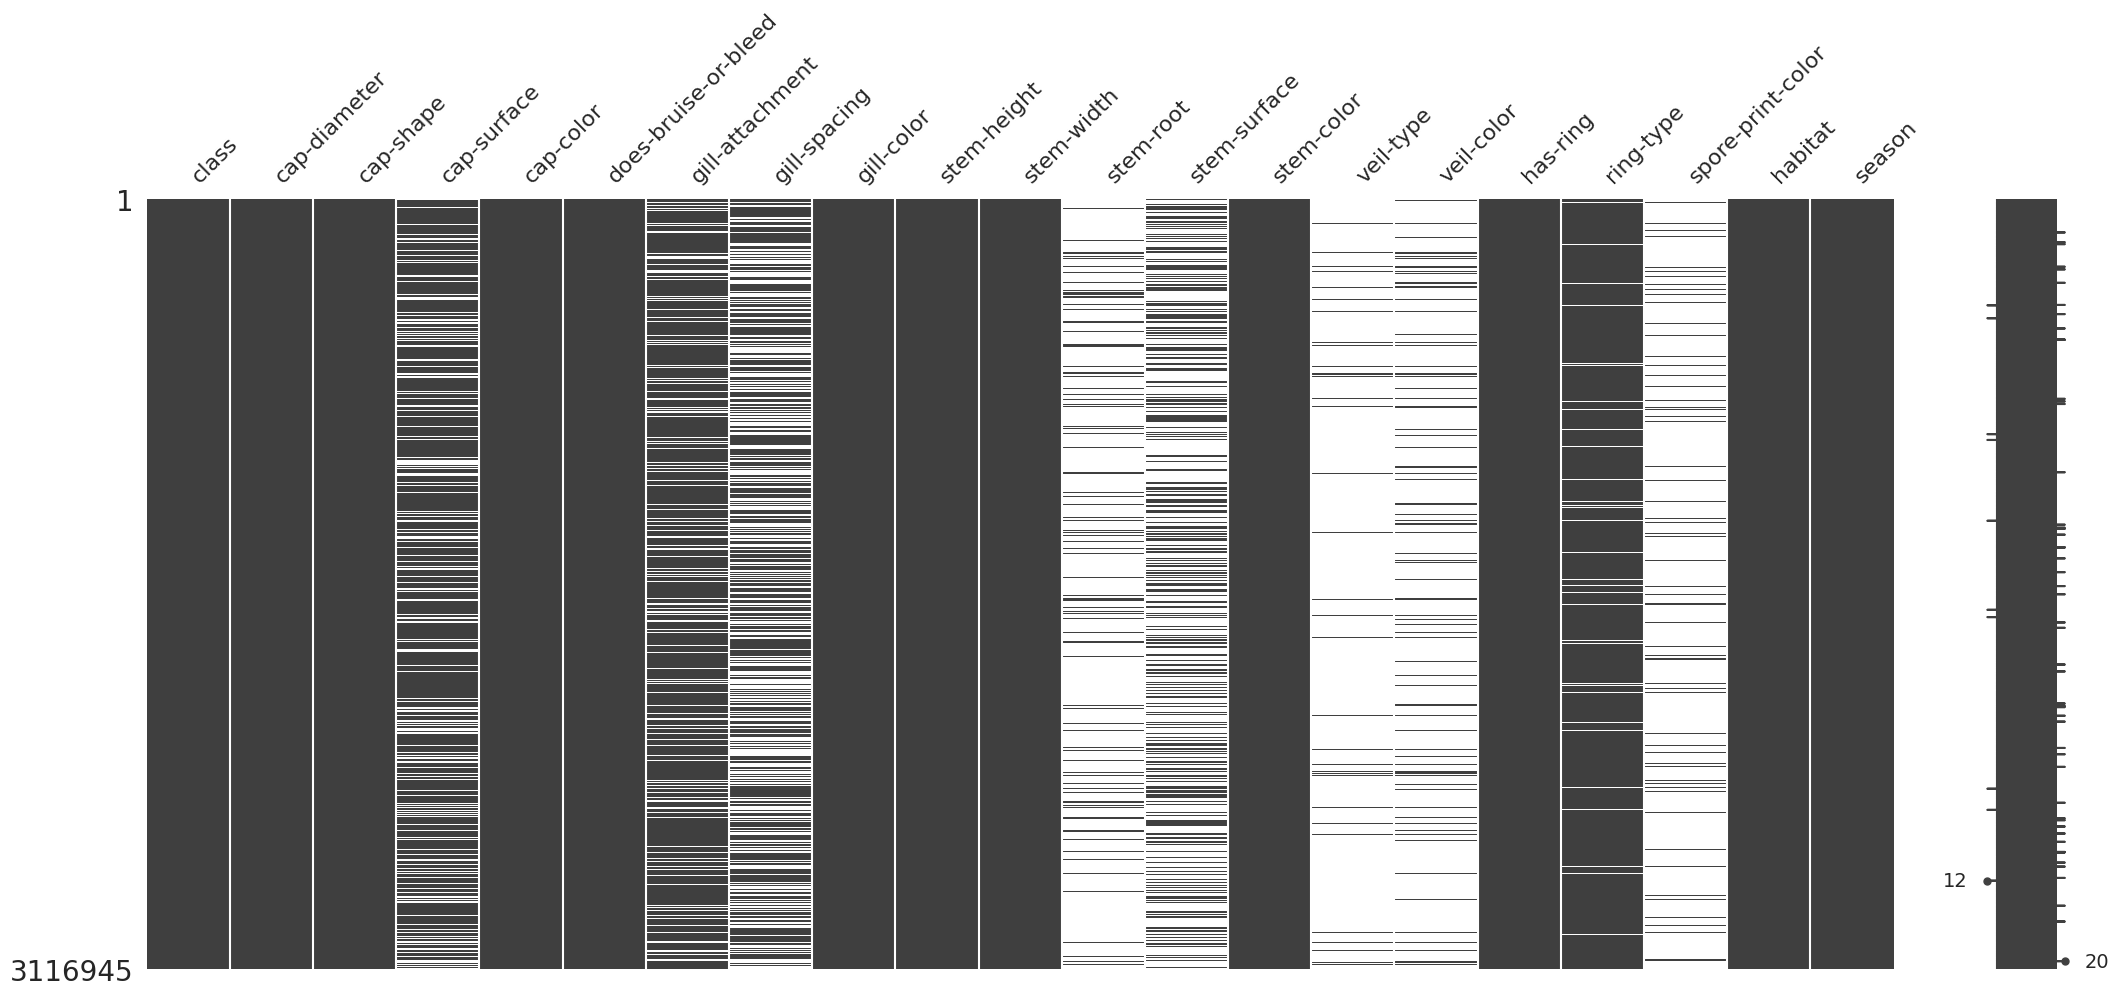

In [8]:
# Visualizing null/missing values in 'train' dataset as a matrix
msno.matrix(train)

<Axes: >

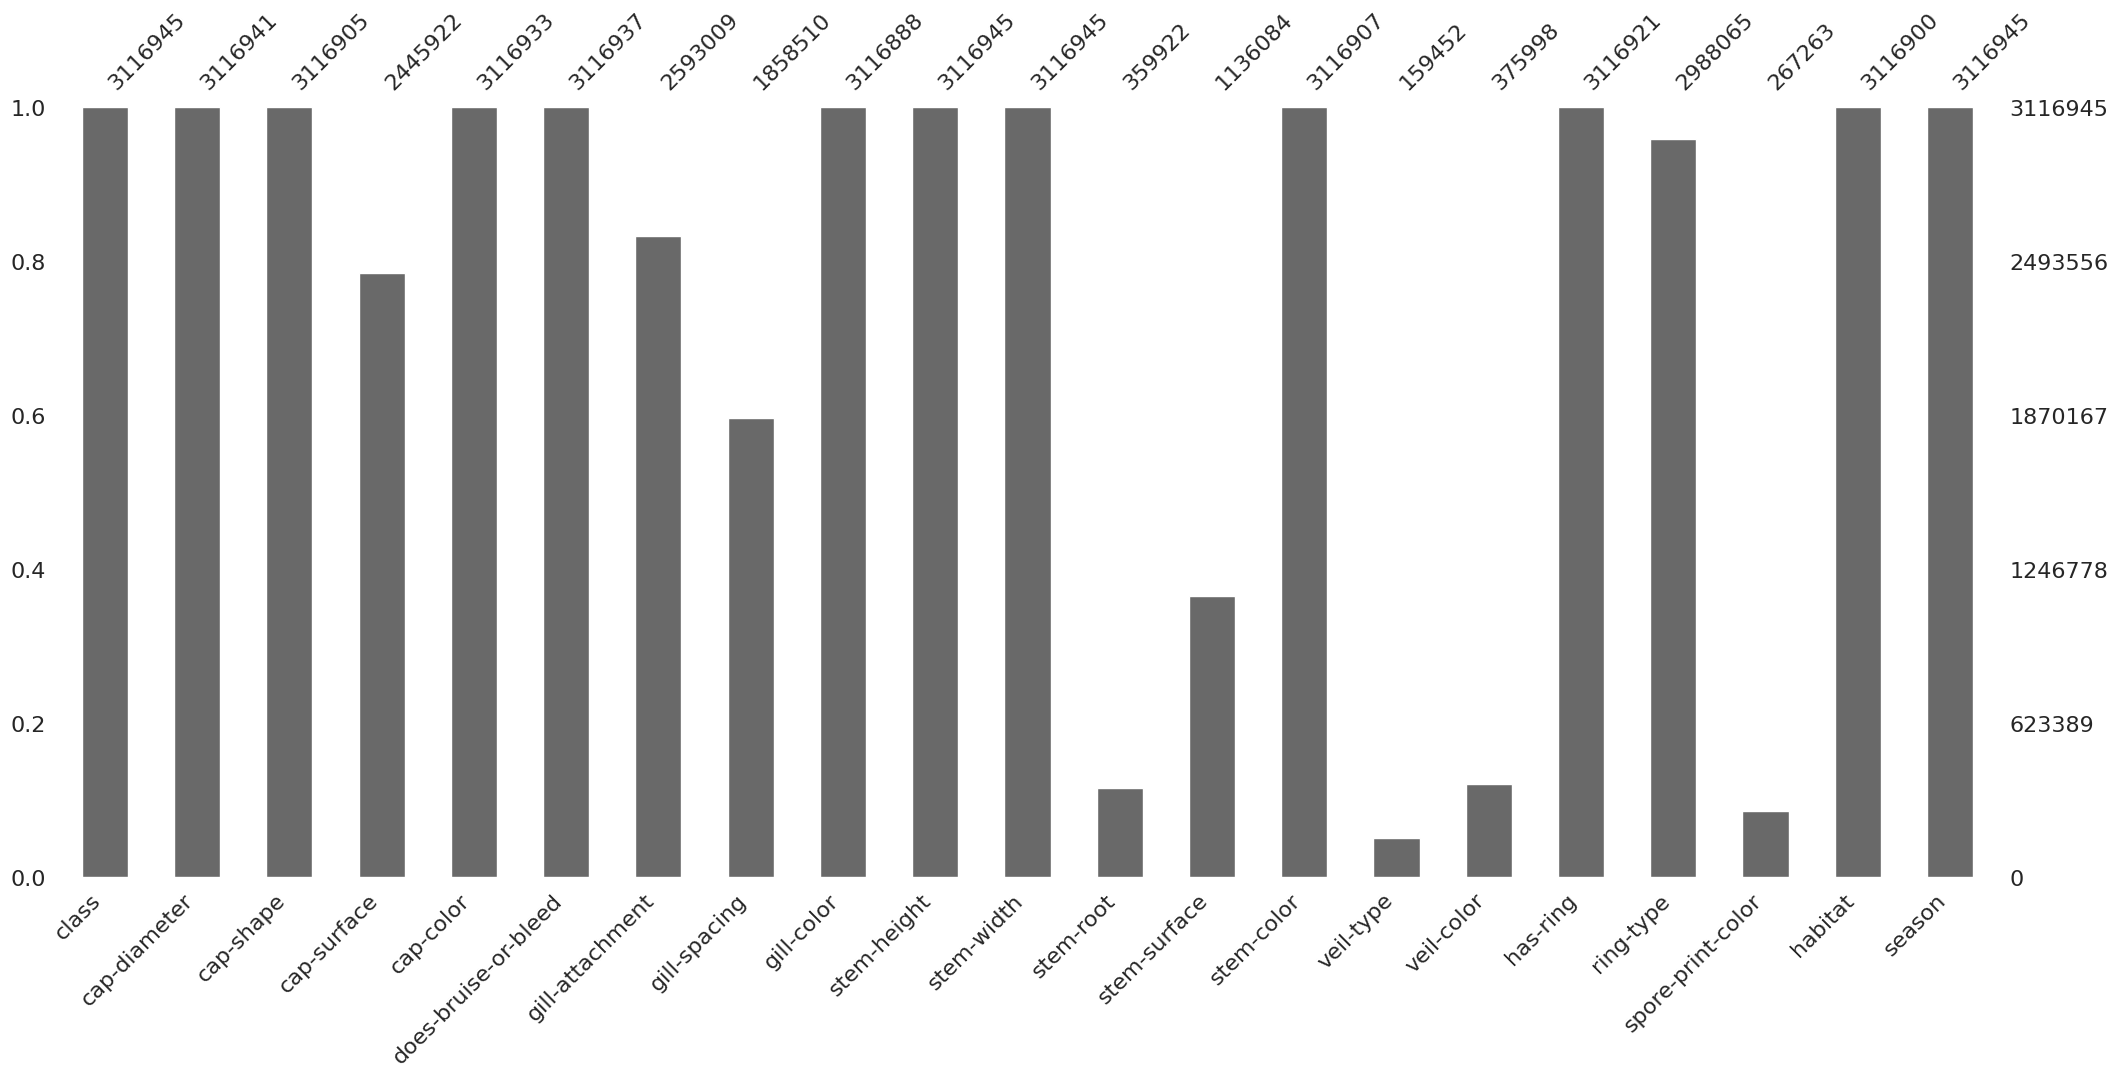

In [9]:
# Visualizing null/missing values in 'train' dataset as a bar chart
msno.bar(train)

The two lines of code above provide a visualization of the proportion of missing entries in the train dataset. The first visualization provides a matrix view, while the second provides a bar chart. Both of these plots clearly show that the aforementioned features ('stem-root', 'veil-type', 'veil-color', 'spore-print-color') are missing more than 80% of the total amount of entries. 

In [10]:
# Dropping features with >80% null/missing values
drop_cols = ['stem-root', 'veil-type', 'veil-color', 'spore-print-color']
train_cleaned = train.drop(columns=drop_cols)
test_cleaned = test.drop(columns=drop_cols)

To remedy the presence of missing data, we are simply going to remove the columns that contain more than 80% null/missing values. These columns include 'stem-root', 'veil-type', 'veil-color', and 'spore-print-color'. Other columns that contain fewer missing values, such as 'cap-diameter' and 'stem-height' can be filled in with median values, which will be done below. 

In [11]:
# Specifying categorical feature columns
cat_cols = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 
            'gill-attachment', 'gill-spacing', 'gill-color', 'stem-surface', 
            'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']

The code above specifies all object type columns and saves them under the variable 'cat_cols'. This will be used below. 

In [12]:
# Filling in null values for categorical columns as 'missing'
# Categorizing all 'cat_cols' (objects) as 'category' dtype
for col in cat_cols:
    train_cleaned[col] = train_cleaned[col].fillna('missing')
    test_cleaned[col] = test_cleaned[col].fillna('missing')
    train_cleaned[col] = train_cleaned[col].astype('category')
    test_cleaned[col] = test_cleaned[col].astype('category')

For the other object type (categorical) columns with missing values, I have decided to fill all empty rows with the string 'missing'. By doing so, we can still use these particular columns in the model. The code chunk above fills all missing values with 'missing' and then converts all object type columns into the 'category' datatype. This will allow these columns/features to be used in the model. These steps are completed for both the train and test datasets, which are now named train_cleaned and test_cleaned. 

In [13]:
# Filling in null values for 'cap-diameter' with its median value
train_cleaned['cap-diameter'] = train_cleaned['cap-diameter'].fillna(train_cleaned['cap-diameter'].median())
test_cleaned['cap-diameter'] = test_cleaned['cap-diameter'].fillna(test_cleaned['cap-diameter'].median())

Previously, we determined that 'cap-diameter' contained 4 missing values in the train dataset and 7 missing values in the test dataset. To remedy this, the code above fills in these missing values with the median value of the column. This has been completed for both the train_cleaned and test_cleaned datasets.

In [14]:
# Filling in null values for 'stem-height' with its median value (only required for 'test' dataset)
test_cleaned['stem-height'] = test_cleaned['stem-height'].fillna(test_cleaned['stem-height'].median())

As with before, this code fills in the missing values in the 'stem-height' column in the test_cleaned dataset with the median value. It was found that the train dataset did not have missing values in this particular column so this change is only applied to the test dataset. 

In [15]:
# Verifying changes to datatypes for 'train_cleaned' dataset
train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3116945 entries, 0 to 3116944
Data columns (total 17 columns):
 #   Column                Dtype   
---  ------                -----   
 0   class                 object  
 1   cap-diameter          float64 
 2   cap-shape             category
 3   cap-surface           category
 4   cap-color             category
 5   does-bruise-or-bleed  category
 6   gill-attachment       category
 7   gill-spacing          category
 8   gill-color            category
 9   stem-height           float64 
 10  stem-width            float64 
 11  stem-surface          category
 12  stem-color            category
 13  has-ring              category
 14  ring-type             category
 15  habitat               category
 16  season                category
dtypes: category(13), float64(3), object(1)
memory usage: 157.6+ MB


Above, we can confirm the changes to the datatypes of each column in the train_cleaned dataset. It appears as though the changes from above were successful, as all object type columns (excluded the target 'class') are now listed as category datatype. 

In [16]:
# Verifying absence of null values in 'train_cleaned'
train_cleaned.isna().sum()

class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-surface            0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

Above, we can confirm that each column in the train_cleaned dataset contains no null or missing values. 

In [17]:
# Verifying changes to datatypes for 'test_cleaned' dataset
test_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2077964 entries, 3116945 to 5194908
Data columns (total 16 columns):
 #   Column                Dtype   
---  ------                -----   
 0   cap-diameter          float64 
 1   cap-shape             category
 2   cap-surface           category
 3   cap-color             category
 4   does-bruise-or-bleed  category
 5   gill-attachment       category
 6   gill-spacing          category
 7   gill-color            category
 8   stem-height           float64 
 9   stem-width            float64 
 10  stem-surface          category
 11  stem-color            category
 12  has-ring              category
 13  ring-type             category
 14  habitat               category
 15  season                category
dtypes: category(13), float64(3)
memory usage: 89.2 MB


Again, we can confirm that all object type columns have been converted to category type columns in the test_cleaned dataset. 

In [18]:
# Verifying absence of null values in 'test_cleaned'
test_cleaned.isna().sum()

cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-surface            0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

And lastly, we can verify that the test_cleaned dataset contains no null or missing values! With these confirmations, the data preprocessing is complete and the data is now ready for exploratory data analysis and model building. 

---

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#6" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="5"></a>
# **Brief EDA**

Now that the data has been cleaned and preprocessed, we can now take a quick look into some basic exploratory data analysis. This section aims to quickly visualize the structure of the target variable 'class' and the structures of a few feature variables. 

In [19]:
# Creating function which plots donut charts for categorical variables
def showplot(columnname):
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax = ax.flatten()
    value_counts = train[columnname].value_counts()
    labels = value_counts.index.tolist()
    colors =["#4caba4", "#d68c78",'#a3a2a2','#ab90a0', '#e6daa3', '#6782a8', '#8ea677']
    
    # Donut Chart
    wedges, texts, autotexts = ax[0].pie(
        value_counts, autopct='%1.1f%%',textprops={'size': 9, 'color': 'white','fontweight':'bold' }, colors=colors,
        wedgeprops=dict(width=0.35),  startangle=80,   pctdistance=0.85  )
    # circle
    centre_circle = plt.Circle((0, 0), 0.6, fc='white')
    ax[0].add_artist(centre_circle)
    
    # Count Plot
    sns.countplot(data=train, y=columnname, ax=ax[1], palette=colors, order=labels)
    for i, v in enumerate(value_counts):
        ax[1].text(v + 1, i, str(v), color='black',fontsize=10, va='center')
    sns.despine(left=True, bottom=True)
    plt.yticks(fontsize=9,color='black')
    ax[1].set_ylabel(None)
    plt.xlabel("")
    plt.xticks([])
    fig.suptitle(columnname, fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

The code chunk above creates a function that works to create visualizations of categorical variables (including the target variable) in the form of donut charts and count plots. 

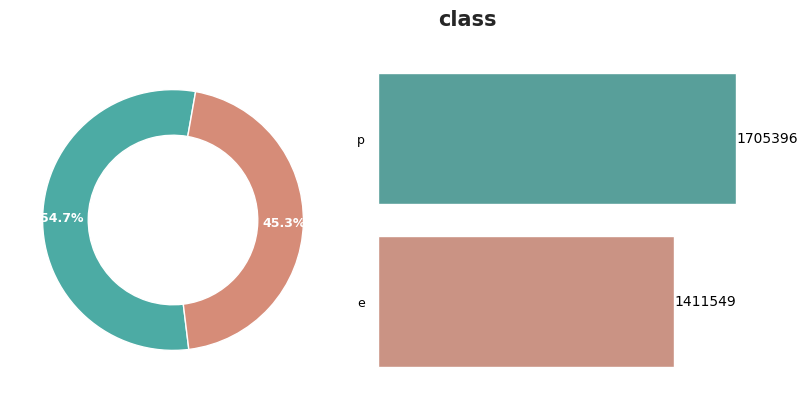

In [20]:
# Visualizing the distribution of the target variable 'class'
showplot('class')

Above, we can see the distribution of the target variable 'class'. At a glance, the distribution appears to be relatively equal, with roughly 45.3% of mushrooms being labeled as edible (e) and roughly 54.7% of mushrooms being labeled as poisonous (p). 

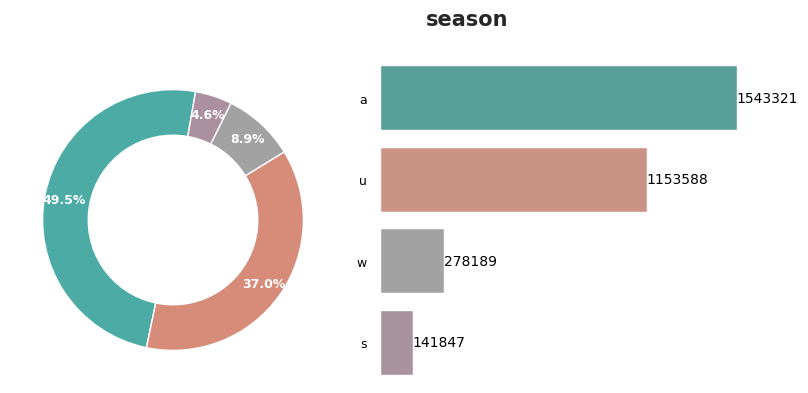

In [21]:
# Visualizing the distribution of feature variable 'season'
showplot('season')

Above, we can see the distribution of the feature variable 'season'. Here, we can see the distributions of mushrooms found in each season. At a glance, we can determine that the majority of mushrooms include the season label autumn (a) and the majority summer (s). 

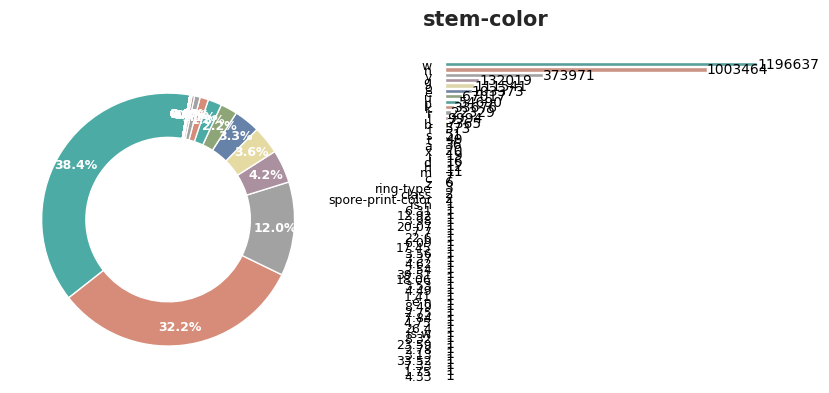

In [22]:
# Visualizing the distribution of feature variable 'stem-color'
showplot('stem-color')

Above, we can see the distribution of the feature variable 'stem-color'. I chose to highlight this particular variable as it demonstrates how many of these categorical variables contain a relatively large amount of categories. Because of this, this chart is not nearly as intuitive as the 'season' chart above. Despite this, it is clear that mushrooms can exhibit great variety in their stem color. 

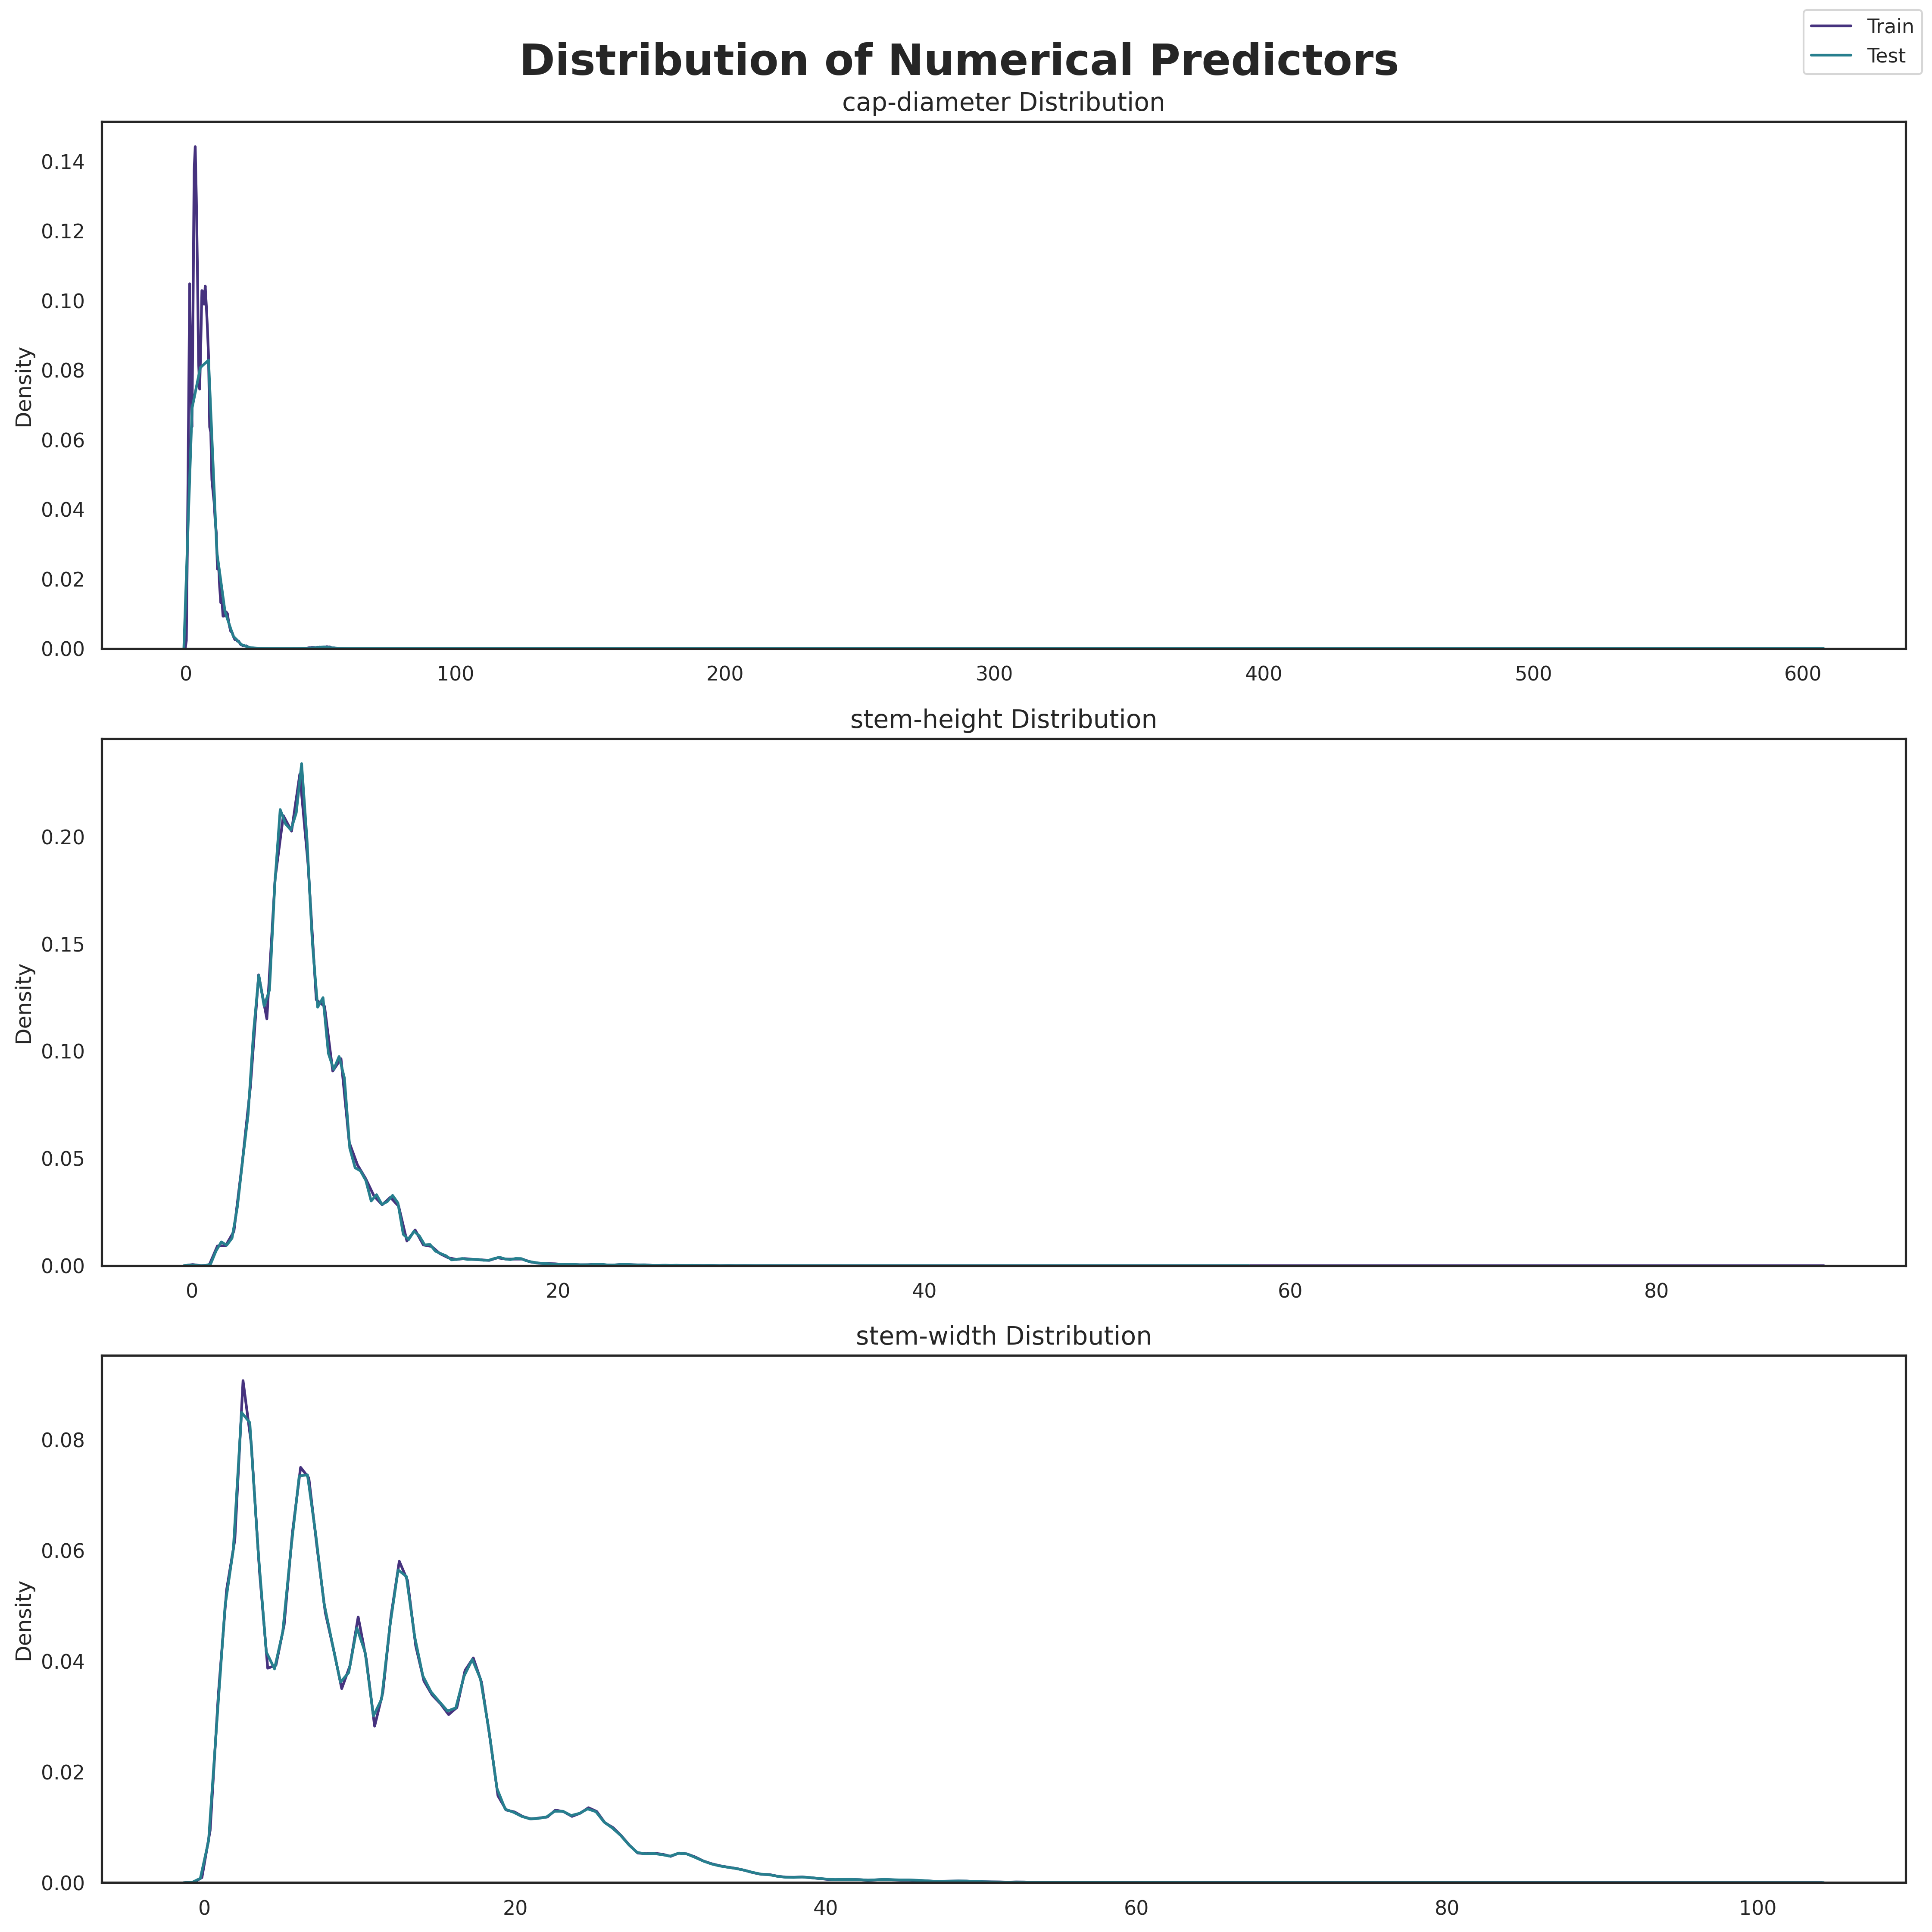

In [23]:
# Visualizing distributions of all numerical predictors (kde plots)
fig, ax = plt.subplots(3, 1, figsize = (15, 15), dpi = 300)
ax = ax.flatten()
train_numerical = train_cleaned[['cap-diameter', 'stem-height', 'stem-width']]
features = train_numerical.columns

for i, column in enumerate(features):
        
    sns.kdeplot(train_cleaned[column], ax=ax[i], color=pal[0])
    sns.kdeplot(test_cleaned[column], ax=ax[i], color=pal[2], warn_singular = False)
    
    ax[i].set_title(f'{column} Distribution', size = 14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Numerical Predictors', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

The code chunk above creates kernel density estimator plots for each of the numerical features ('cap-diameter', 'stem-height', 'stem-width'). These plots essentially show the value distributions of each of these features. For example, 'stem-width' appears to have the highest distribution of values around 1 and the distribution appears to drop off significantly after 20. 

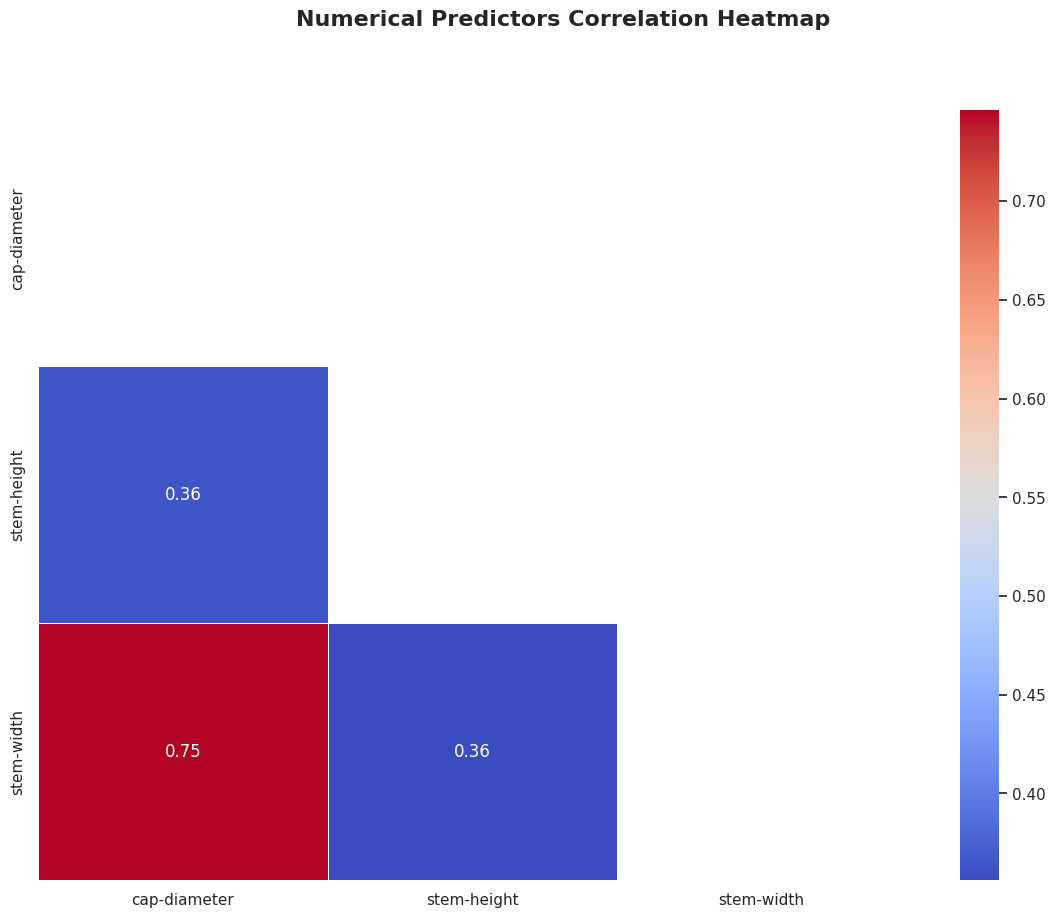

In [24]:
# Plotting correlation heatmap of numerical predictors
plt.figure(figsize=(14,10))
corr=train_numerical.corr()
sns.heatmap(corr,annot=True,cmap='coolwarm',mask=np.triu(corr), linewidths=0.5, fmt=',.2f')
plt.suptitle('Numerical Predictors Correlation Heatmap', fontsize=16, fontweight='bold')
plt.show()

Above, we can see a heatmap of the three numerical predictors. While rudimentary, we can see that there is a roughly significant positive relationship between 'stem-width' and 'cap-diameter' at 0.75. This may suggest that as the value of one of these features increases, so may the other. This may seem fairly obvious, as it seems plausible that a mushroom with a thicker stem may also have a thicker cap. 

---

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#7" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="6"></a>
# **Building & Training the Model**

This section builds and trains the LGBM model. 

In [25]:
# Creating training dataset 'X', which does not include the target variable 'class'
X = train_cleaned.drop('class', axis=1)
X.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-surface,stem-color,has-ring,ring-type,habitat,season
id,,,,,,,,,,,,,,,,
0,8.80,f,s,u,f,a,c,w,4.51,15.39,missing,w,f,f,d,a
1,4.51,x,h,o,f,a,c,n,4.79,6.48,y,o,t,z,d,w
2,6.94,f,s,b,f,x,c,w,6.85,9.93,s,n,f,f,l,w
3,3.88,f,y,g,f,s,missing,g,4.16,6.53,missing,w,f,f,d,u
4,5.85,x,l,w,f,d,missing,w,3.37,8.36,missing,w,f,f,g,a


Prior to building the model, the data must be further altered. Here, I have dropped the target variable 'class' from the train_cleaned dataset and have assigned this new dataset to the variable 'X'. 

In [26]:
# Creating testing dataset 'y', which includes just the target variable 'class'
y = train_cleaned['class']
y.head()

id
0    e
1    p
2    e
3    e
4    e
Name: class, dtype: object

Conversely, the new dataset 'y' now contains just the target variable 'class' from the train_cleaned dataset. The 'X' and 'y' datasets will now be split into training and validation sets.

In [27]:
# Splitting the training and validation sets, 80/20 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

The code above splits the data into training and validation sets. Both 'X' and 'y' essentially receive a training and validation set. 20% of the data has been partitioned/withheld for the purpose of validation. Also, I set the random state to 42 for reproducable results. 

In [28]:
clf = LGBMClassifier(objective='binary', metric='binary_error', 
                     num_leaves=81, learning_rate=0.05, 
                     n_estimators=600, max_depth= 9, 
                     random_state=42)

The code above sets up the LGBM classifier. Here, we must declare certain parameters for the model. The 'objective' has been set to 'binary', as this is a binary classification task. The 'metric' has also been set to 'binary_error' to reflect this particular class. The 'num_leaves' parameter has been set to 81. This provides the value of the number of leaves in the tree model. The 'learning_rate' represents the shrinkage rate of the model and a smaller learning rate usually improves accuracy. This has been set to 0.05. The 'n_estimators' essentially represents the number of boosting iterations and has been set to 600. 'Max_depth' has been set to 9, which limits the max depth of the tree model to 9 layers. And again, 'random_state' has been set to 42 for reproducible results. 

In [29]:
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.718163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251


LGBMClassifier(learning_rate=0.05, max_depth=9, metric='binary_error',
               n_estimators=600, num_leaves=81, objective='binary',
               random_state=42)

The code line above fits the model to the training data. 

In [30]:
# Making predictions on the validation data, stored as 'y_pred'
y_pred = clf.predict(X_val)

The code line above uses the model to make predictions on the validation data ('X_val'). These predictions are stored as 'y_pred' and will be used later to evaluate the performance of the model. 

---

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#8" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="7"></a>
# **Model Evaluation**

This section evaluates the performance of the final model via its accuracy score, classification report, confusion matrix, and feature importance. 

In [31]:
# Checking the accuracy score of the final model
print('Accuracy score: ', accuracy_score(y_val, y_pred))

Accuracy score:  0.9918124958894046


Above we can see how the predictions made by the model (stored in 'y_pred') compare to the validation data ('y_val'). Here, we can see that the model yielded an accuracy score of ~99.18%. That's pretty good! 

In [32]:
# Viewing the classification report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           e       0.99      0.99      0.99    282397
           p       0.99      0.99      0.99    340992

    accuracy                           0.99    623389
   macro avg       0.99      0.99      0.99    623389
weighted avg       0.99      0.99      0.99    623389



Here, we can see the classification report of the final model. The precision column tells us the accuracy of positive predictions, i.e. precision = true positives / (true positives + false positives). Next, the recall column tells us the fraction of correctly identified positive predictions, i.e. recall = true positives / (true positives + false negatives). Lastly, The f1-score essentially measures the harmonic mean of the precision and recall values. Fortunately, the model yielded scores of ~0.99 in all of these metrics. 

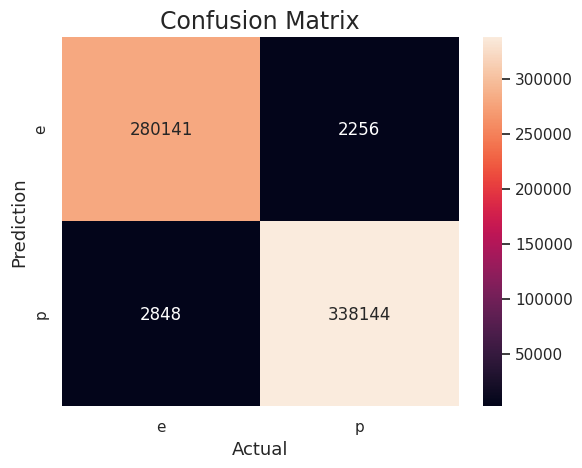

In [33]:
# Viewing the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred, labels=clf.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=clf.classes_,
            yticklabels=clf.classes_,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

The confusion matrix above provides more insight into how the final model performed. Here, we can see how many times the predicted classes matched the actual classes. For mushrooms that were actually edible, the model labeled them as edible 280,141 times and only incorrectly labeled them as poisonous 2,848 times. In contrast, poisonous mushrooms were correctly labeled 338,144 times and incorrectly labeled only 2,256 times. 

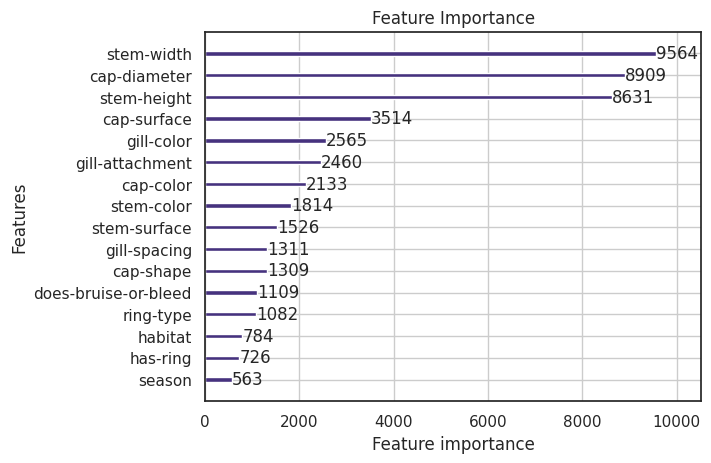

In [34]:
# Visualizing feature importance
plot_importance(clf, title='Feature Importance')
plt.show()

Lastly, we can take a look at the feature importance, i.e. which predictors are most useful or impactful at predicting the target variable. In other words, which characteristics of a mushroom may provide significant clues as to whether or not the mushroom is edible or poisonous for this particular LGBM model. Here, we can see that the three numerical predictors ('stem-width', 'cap-diameter', 'stem-height') were the most impactful on the model. Following this, 'cap-surface' (a categorical feature) was the next most impactful. 

---

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="toc"></a>

<a href="#9" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="toc"></a>

<a id="8"></a>
# **Kaggle Submission**

This section prepares the predictions for submission to the Kaggle competition. The predictions will be added to Kaggle's submission file and then exported as a .csv file. 

In [35]:
# Making final predictions on the test set
predictions = clf.predict(test_cleaned)

In [36]:
# Importing Kaggle 'sample_submission' dataset
submission = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')

In [37]:
# Applying final predictions to submission dataset
submission['class'] = predictions
submission.head()

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e


In [38]:
# Creating .csv file for submissions and scoring
run = 0

if run == 1:
    submission.to_csv('submission.csv', index=False)

---

<a id="toc"></a>

<a href="#toc" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="9"></a>
# **Conclusion**

The goal of this project was to predict whether or not a mushroom would be edible or poisonous based upon its physical characteristics. In order to solve this binary classification task, a LightGBM model was built and fit to the data. Prior to this, the data was cleaned and preprocessed by eliminating columns with more than 80% missing data. The remaining columns with missing/null values were filled with either 'missing' (for categorical variables) or the median value (for numerical variables). The final model yielded an accuracy score on the validation data of roughly 99.18%. A classification report found that precision, recall, and f1-score were all 0.99. Next, a confusion matrix demonstrated the model's prediction accuracies. More specifically, for mushrooms that were actually edible, the model labeled them as edible 280,141 times and only incorrectly labeled them as poisonous 2,848 times. In contrast, poisonous mushrooms were correctly labeled 338,144 times and incorrectly labeled only 2,256 times. Lastly, it was found that the three numerical predictors ('stem-width', 'cap-diameter', 'stem-height') were the most impactful on the model. Following this, the most impactful categorical predictor was 'cap-surface'. 

---

<a id="toc"></a>

<a id="r"></a>
# **References**

- https://www.kaggle.com/competitions/playground-series-s4e8/overview
- https://www.activewild.com/mushroom-facts/#Types_Of_Mushrooms
- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://archive.ics.uci.edu/dataset/73/mushroom
- https://www.kaggle.com/code/ahmedgaitani/poisonous-mushrooms-code-lgbm
- https://www.kaggle.com/code/conradkleykamp/s4e2-obesity-classification-w-lightgbm
